In [23]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.transform import resize
from torchvision.models import alexnet
import torch
import torchvision.transforms as transforms
from PIL import Image

alexnet = alexnet(pretrained=True)

/home/arcarolab_adm/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/arcarolab_adm/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
# Function to register hooks
def get_features(model, layer_names):
    features = {}

    def make_hook(layer_name):
        def hook(module, input, output):
            features[layer_name] = output
        return hook

    for name, layer in model.named_modules():
        if name in layer_names:
            layer.register_forward_hook(make_hook(name))

    return features

In [28]:
imageSet = 'Kiani_ImageSet_norm_quad'
# Load AlexNet
# Initialize AlexNet model
alexnet.eval()

# Initialize parameters
imgSize = [1.25,2.5,5,10]
dist_matrix = []
target_size = (227, 227)
species = 'treeshrew'

# Desired order
desired_order = ["humanbody", "humanface", "nothumanbody", "nothumanface", "natural", "artificial"]

# Create a dictionary to map directory names to their order
order_dict = {name: index for index, name in enumerate(desired_order)}

# Initialize the transform
transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Specify the layers you want to extract features from
layer_names = ['features.0', 'features.3', 'features.6', 'features.8', 'features.10', 'classifier.1', 'classifier.4', 'classifier.6']

# Register hooks
features = get_features(alexnet, layer_names)

# Initialize all_layers to store features for each layer
# all_layers = [[[] for _ in range(len(layer_names))] for _ in range(len(imgSize))]
all_layers = np.empty((len(imgSize), len(layer_names)), dtype=object)

for im_idx, img_size in enumerate(imgSize):
    # Get directory names
    dir_names = glob.glob(f'../stimulusSets/isettreeshrew/{species}_{img_size}/{imageSet}/*')

    # Split directory names and get string after last '/' then match the first part of the string to desired order regardless of suffix
    sorted_dir_names = sorted(dir_names, key=lambda x: order_dict[x.split('/')[-1].split('_')[0]])

    # Plot the distance matrix for each image size
    all_lay = [[] for _ in layer_names]

    # Get all images in each directory
    for dir_idx, dir_name in enumerate(sorted_dir_names):
        if imageSet.endswith('_quad'):
            dir_name = dir_name+'/merged/'
            
        allImgs = os.listdir(dir_name+'/')
        # exclude images that start with '.'
        images = [img for img in allImgs if not img.startswith('.') and (img.endswith('.jpg') or img.endswith('.bmp'))]
        for i in range(len(images)):
            # Load image
            img = plt.imread(dir_name + '/' + images[i])

            # Ensure the image has 3 channels
            if (len(img.shape) == 2):
                img = np.expand_dims(img, axis=2)
                img = np.repeat(img, 3, axis=2)
            elif (img.shape[2] == 1):
                img = np.repeat(img, 3, axis=2)
            elif img.shape[2] == 4:
                img = img[:, :, :3]

            # Convert to uint8
            img = (img * 255).astype(np.uint8)
            img_pil = Image.fromarray(img)  # Convert to PIL Image
            img_transform = transform(img_pil)  # Apply the transform

            with torch.no_grad():
                _ = alexnet(img_transform.unsqueeze(0))  # Forward pass to trigger hooks

            # Collect features from specified layers
            for idx, layer_name in enumerate(layer_names):
                layer_output = features[layer_name].view(features[layer_name].size(0), -1)
                all_lay[idx].append(layer_output.numpy())

    # Convert lists to numpy arrays
    for idx, layer in enumerate(all_lay):
        all_layers[im_idx,idx] = all_lay[idx]

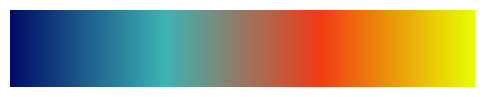

In [29]:
from matplotlib.colors import LinearSegmentedColormap

rgb_colors = [
    (0, 12, 104),
    (61,180,180),
    (240,60,20),
    (232,255,0)
]

rgb_colors_normalized = [(r/255,g/255,b/255) for r,g,b in rgb_colors]

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", rgb_colors_normalized)

gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.figure(figsize=(6, 1))
plt.imshow(gradient, aspect='auto', cmap=custom_cmap)
plt.axis('off')
plt.show()

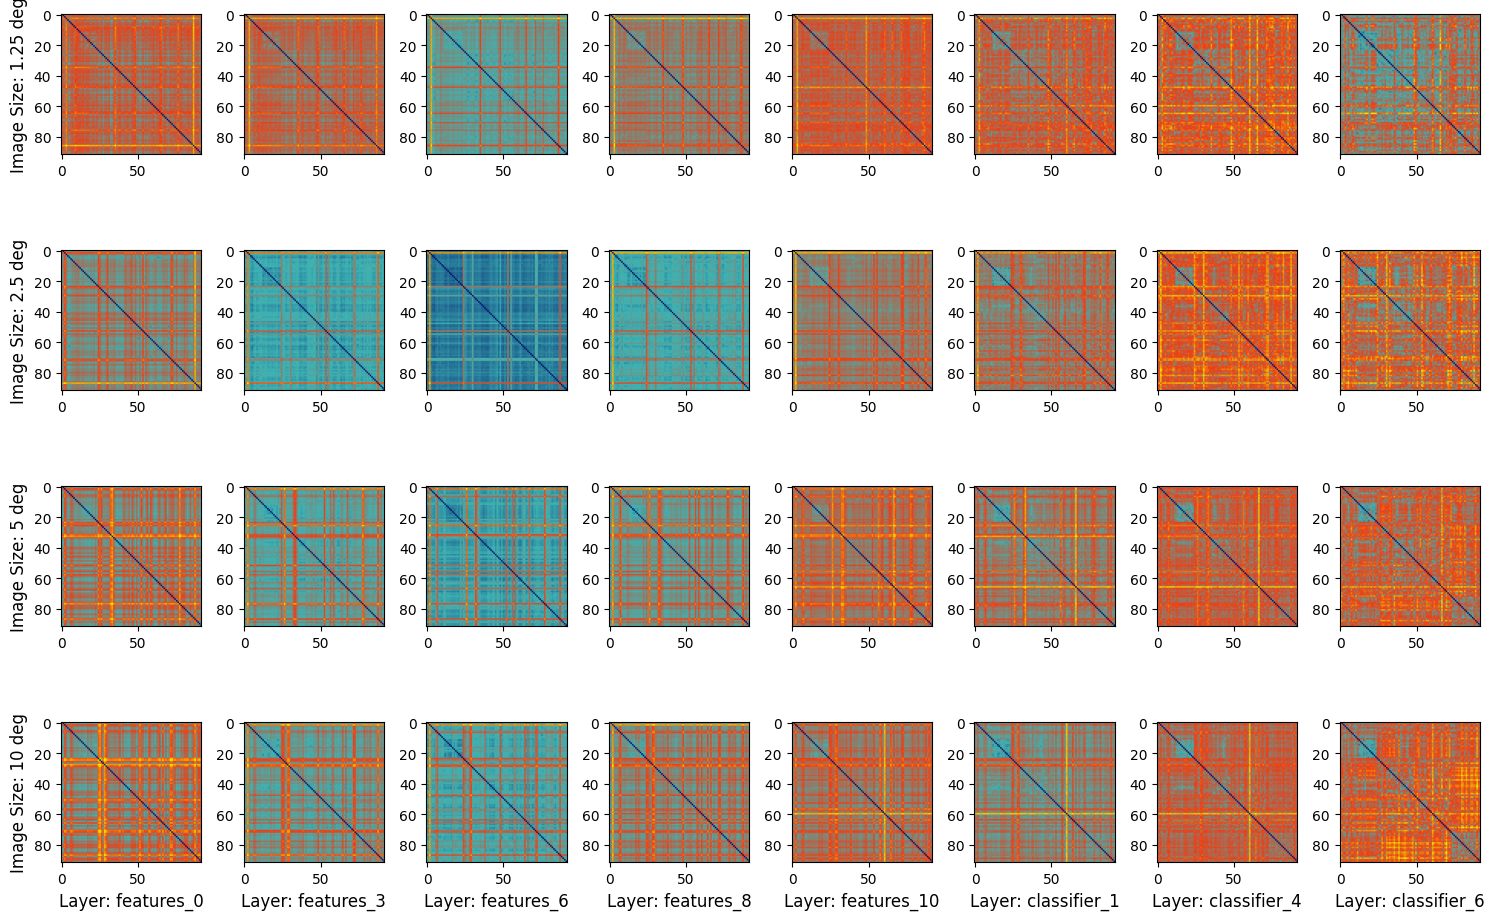

In [30]:
dist = np.zeros((len(imgSize), len(layer_names)), dtype=object)
nImgs = len(all_layers[0,0])
plt.figure(figsize=(15,10))
for im_idx, img_size in enumerate(imgSize):
    for layer_idx, layer_name in enumerate(layer_names):
        dist[im_idx, layer_idx] = np.zeros((nImgs, nImgs))
        for idx1 in range(nImgs):
            for idx2 in range(nImgs):
                feat1 = all_layers[im_idx, layer_idx][idx1]
                feat2 = all_layers[im_idx, layer_idx][idx2]
                dist[im_idx, layer_idx][idx1,idx2] = np.linalg.norm(feat1 - feat2)
        
        norm_dist = dist[im_idx, layer_idx] / np.max(dist[im_idx, layer_idx])
        plt.subplot(len(imgSize), len(layer_names), im_idx*len(layer_names) + layer_idx + 1)
        plt.imshow(norm_dist, cmap=custom_cmap)

        if layer_idx == 0:
            plt.ylabel('Image Size: ' + str(img_size) + ' deg', fontsize=12)

        if im_idx == len(imgSize) - 1:
            plt.xlabel('Layer: ' + layer_name.replace('.', '_'), fontsize=12)

plt.tight_layout()
plt.savefig(f'./DNNDistanceData/{species}_DNNDistanceMatrix.png', dpi=300)
plt.savefig(f'./DNNDistanceData/{species}_DNNDistanceMatrix.svg', dpi=300)
plt.show()


# Make dist a dictionary with keys as layer names and image sizes
dist_dict = {}
for im_idx, img_size in enumerate(imgSize):
    for layer_idx, layer_name in enumerate(layer_names):
        key = f'ImgSize_{img_size}_Layer_{layer_name.replace(".", "_")}'
        dist_dict[key] = dist[im_idx, layer_idx] / np.max(dist[im_idx, layer_idx])

# Save the distance matrices
np.save(f'./DNNDistanceData/{species}DistMat.npy', dist_dict)

In [36]:
# Find coordinate of max value of dist_dict[0,0]
max_index = np.unravel_index(np.argmax(dist_dict['ImgSize_1.25_Layer_features_0']), dist_dict['ImgSize_1.25_Layer_features_0'].shape)
print(f'Max value index in dist_dict[0,0]: {max_index}')
y = dist_dict['ImgSize_1.25_Layer_features_0']

Max value index in dist_dict[0,0]: (3, 86)


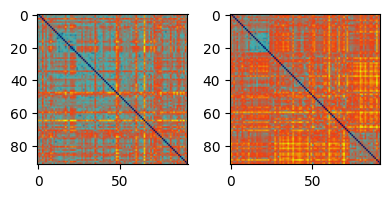

treeshrew_125 vs treeshrew_10: 0.1954


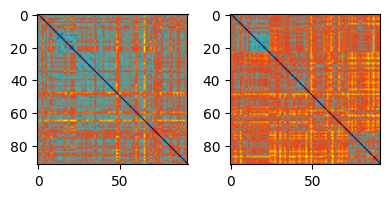

treeshrew_125 vs human_125: 0.1130


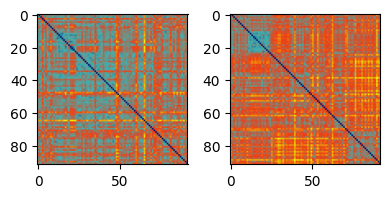

treeshrew_125 vs human_10: 0.0749


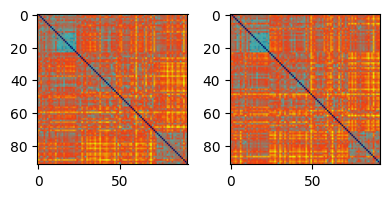

treeshrew_10 vs human_125: 0.2979


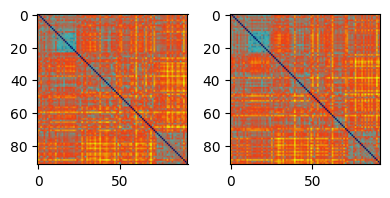

treeshrew_10 vs human_10: 0.4076


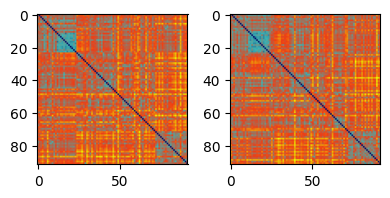

human_125 vs human_10: 0.3001


In [41]:
treeshrew_dist = np.load('./DNNDistanceData/treeshrewDistMat.npy', allow_pickle=True).item()
human_dist = np.load('./DNNDistanceData/humanDistMat.npy', allow_pickle=True).item()

treeshrew_125 = treeshrew_dist['ImgSize_1.25_Layer_classifier_6']
treeshrew_10 = treeshrew_dist['ImgSize_10_Layer_classifier_6']
human_125 = human_dist['ImgSize_1.25_Layer_classifier_6']
human_10 = human_dist['ImgSize_10_Layer_classifier_6']

# compute correlations between all lower triangular matrices
from scipy.stats import pearsonr

def compute_correlations(matrices, names):
    correlations = []
    for i in range(len(matrices)):
        for j in range(i + 1, len(matrices)):
            # Use only the lower triangle (excluding diagonal) for correlation
            plt.figure(figsize=(4,2))
            plt.subplot(1,2,1)
            plt.imshow(matrices[i], cmap=custom_cmap)
            plt.subplot(1,2,2)
            plt.imshow(matrices[j], cmap=custom_cmap)
            plt.tight_layout()
            plt.show()
            tril_i = matrices[i][np.tril_indices_from(matrices[i], k=-1)]
            tril_j = matrices[j][np.tril_indices_from(matrices[j], k=-1)]
            corr, _ = pearsonr(tril_i, tril_j)
            print(f"{names[i]} vs {names[j]}: {corr:.4f}")
            correlations.append(((names[i], names[j]), corr))
    return correlations

matrices = [treeshrew_125, treeshrew_10, human_125, human_10]
names = ['treeshrew_125', 'treeshrew_10', 'human_125', 'human_10']
correlations = compute_correlations(matrices, names)